# 라이브러리 불러오기

In [2]:
#필요한 library 들을 load 합니다.
import os 
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import numpy as np
import pandas as pd
from tqdm import tqdm
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import seaborn as sns

# Image handling
from torchvision import datasets, transforms
from PIL import Image

# Pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, RandomSampler, SequentialSampler, ConcatDataset
from torchvision import models

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# Augmenting library 
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")

In [3]:
# from glob import glob
# import shutil 


# classes = os.listdir('./data/train/')

# for cls in classes:
#     # 폴더 안에 얼마나 들어갔나
#     n_imgs = len(os.listdir('./data/train/'+ str(cls)))
#     np.sample()
#     print(n_imgs)
#     break

In [4]:
# cifar10_train = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
# cifar10_test = datasets.CIFAR10(root='./data', train=True, transform=None, download=True)

# 데이터 load

이후 추가할 데이터 정규화를 위해, Train 데이터를 모두 훑어주면서 평균과 분산을 찾아줍니다.

In [5]:
temp_transform = T.Compose([
    T.ToTensor(), #이미지 데이터를 tensor 데이터 포멧으로 바꾸어줍니다.
    # T.Resize([224, 224]), #이미지의 크기가 다를 수 있으니 크기를 통일해 줍니다.
    # T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #픽셀 단위 데이터를 정규화 시켜줍니다.
])

In [6]:
train_data = datasets.ImageFolder(root='./data/train/',transform=temp_transform)
print(len(train_data))

50000


임시 dataloader로 데이터를 로드해 줍니다. 

전체 데이터를 훑을 것이기 때문에, 이때 batch_size는 데이터 전체의 길이로 해줍니다.

보통은 하드웨어 성능에 맞춰주며, 최적의 batch_size는 여러분이 정해야 할 하이퍼파라미터입니다.

In [7]:
temp_loader = DataLoader(train_data, batch_size=len(train_data), num_workers=1)
data = next(iter(temp_loader))

데이터 차원 : 갯수 x RGB채널 (C) x 높이(H) x 너비(W)

In [8]:
data[0].shape

torch.Size([50000, 3, 32, 32])

RGB 채널별로 평균과 표준편차를 구해줍니다.

데이터 정규화를 시켜주는 이유는 간단히 다음과 같습니다.

1. 평균을 0, 분산을 1로 만들어줌으로써 학습 속도를 증가

2. Train/Val 과 Test 데이터의 분포가 다름(Dataset Shift Problem)으로써 나오는 악영향을 줄임

등등, https://hyen4110.tistory.com/20

In [9]:
R_mean = data[0][:, 0].mean().numpy()
G_mean = data[0][:, 1].mean().numpy()
B_mean = data[0][:, 2].mean().numpy()

R_std = data[0][:, 0].std().numpy()
G_std = data[0][:, 1].std().numpy()
B_std = data[0][:, 2].std().numpy()

print(R_mean, G_mean, B_mean, R_std, G_std, B_std)

0.49125063 0.48208764 0.44651157 0.24574625 0.24295063 0.26109803


Pytorch는 String 형태의 레이블을 입력받지 못하므로, 숫자형태로 매핑해줍니다.

In [10]:
submission = pd.read_csv('./data/sample_submission.csv')
train_imgs = glob('./data/train/*/*')
train_labels = [path.split('\\')[1] for path in train_imgs]
test_imgs = glob('./data/test/*')

# Pytorch는 String 형태의 label을 입력받지 못합니다.
label_map = {
    'airplane' : 0, 
    'automobile': 1, 
    'bird': 2,
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6,
    'horse': 7, 
    'ship': 8, 
    'truck': 9,
}

# Dataset 정의

In [11]:
class train_dataset(Dataset):
    def __init__(self, imgs, labels, transform = None):
        super(train_dataset, self).__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        assert len(self.imgs) == len(self.labels)
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        y = label_map[self.labels[idx]]
        
        if self.transform:
            img = self.transform(image = X)['image']
        else:
            img = X
    
        y = torch.tensor(y, dtype = torch.long)
        return {
            'img' : img,
            'label' : y
        }
    
class test_dataset(Dataset):
    def __init__(self, imgs, transform = None):
        super(test_dataset, self).__init__()
        self.imgs = imgs
        self.transform = transform
        # self.n_tta = n_tta
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        if self.transform:
            img = self.transform(image = X)['image']
            return img
        else:
            return X

# Config

하이퍼파라미터들을 설정해 줍니다.

batch_size 란 하드웨어에 한번에 load 할 데이터의 크기입니다. 

num_workers 란 데이터 로드 멀티 프로세싱을 위한 파라미터입니다. Windows에서는 따로 설정하면 에러납니다.

Train 데이터 batch_size는 적당한 값, val/test 데이터는 하드웨어가 감당하는 최대한 큰 값으로 하면 좋습니다.

In [12]:
re_size = 224

train_batch_size = 32
valid_batch_size = 64
test_batch_size = 64

epochs = 30
learning_rate = 1e-3

save_name = f'js_effb0_r{re_size}_b{train_batch_size}_lr{learning_rate}_e{epochs}'
save_path = f'models/{save_name}.pt'

# 데이터 증강 (Augmentation)

데이터 형태마다 고유의 증강 기법이 존재합니다. 

증강을 통해 Train 데이터에 변형을 주어 다양성(Variability)를 높이고, Bias를 낮춰 앞서 말한 Dataset shift 문제에 대처할 수 있습니다.

즉, 과적합(Overfitting)에 조금 더 강건한 모델을 만들 수 있습니다.

이미지에는 다음과 같은 증강 기법들이 존재합니다. 컴퓨터 비전 관련한 수업을 들으신 분들은 익숙하실 것입니다.
1. 픽셀 단위 증강 : 가우시안 블러링, 가우시안 노이즈 추가, 픽셀 정규화, Grayscaling 등
2. 공간 수준 증강(Spatial-level Augmentation): Resize, Crop, Rotate, Flip, Shift 등 

- 이외에도 Cutout, Mixup, CutMix, Augmix 등 다양한 증강 기법들이 개발되고 있습니다.

**Validation 및 Test 데이터에는 Augmentation을 적용하면 안 됩니다. (정규화 제외)**
- Test-time Augmentation(TTA)라는 기법이 있긴 하지만, 여기서는 적용하지 않겠습니다.

In [13]:
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose([
    A.Resize(re_size, re_size, interpolation=cv2.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.GaussNoise(p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit = 3, p = 1.0),
        A.MedianBlur(blur_limit = 3, p = 1.0),
        A.Blur(blur_limit = 3, p = 1.0),
        ], p = 0.3),
    A.ShiftScaleRotate(rotate_limit = 30),
    A.OneOf([
        A.OpticalDistortion(p = 1.0),
        A.GridDistortion(p = 1.0),
        ], p = 0.3),
    A.OneOf([
        A.CLAHE(clip_limit = 2),
        A.RandomBrightnessContrast(),
        ], p = 0.3),
    A.HueSaturationValue(p = 0.3),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

else_transform = A.Compose([
    A.Resize(re_size, re_size, interpolation=cv2.INTER_AREA),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

Train/Val split

In [14]:
train_data = datasets.ImageFolder(root='./data/train/',transform=temp_transform)
train_imgs = glob('./data/train/*/*')
train_labels = [path.split('\\')[1] for path in train_imgs]
test_imgs = glob('./data/test/*')

# Pytorch는 String 형태의 label을 입력받지 못합니다.
label_map = {
    'airplane' : 0, 
    'automobile': 1, 
    'bird': 2,
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6,
    'horse': 7, 
    'ship': 8, 
    'truck': 9,
}

train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size = 0.2, 
                                                                  stratify = train_labels, random_state = 42)
len(train_imgs), len(val_imgs), len(train_labels), len(val_labels)

(40000, 10000, 40000, 10000)

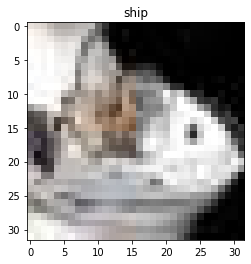

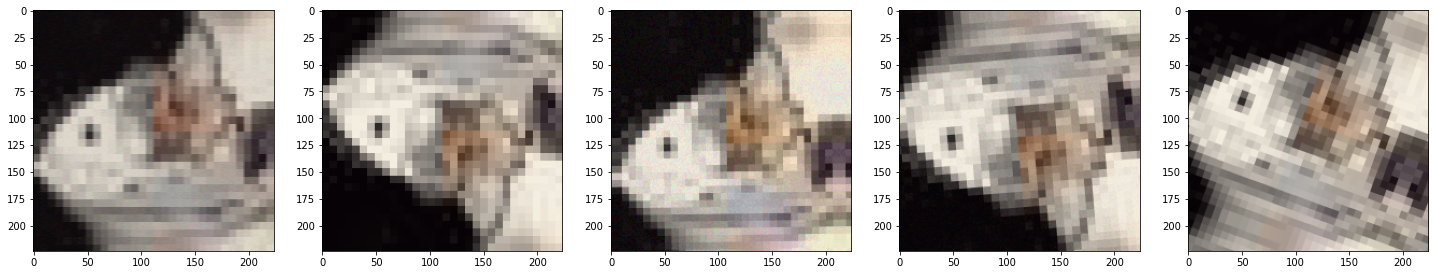

In [15]:
def display_aug(imgs, transform, labels = None, n_aug = 5, cols = 5):
    idx = random.randint(0, len(imgs) - 1)
    
    plt.imshow(np.array(Image.open(imgs[idx])))
    
    if labels:
        label = labels[idx]
        plt.title(label)
    plt.show()
    
    rows = int(np.ceil(n_aug / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 5, rows * 5))

    for i in range(n_aug):
        img = np.array(Image.open(imgs[idx]))
        img = transform(image = img)['image']
        img = np.clip(img.numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        axes.flat[i].imshow(img)
    plt.show()

display_aug(train_imgs, train_transform, labels = train_labels)

data loader 를 생성해줍니다. 

data loader 란 데이터 셋을 순회하며 모델에 데이터를 넣어주는 객체입니다. 

In [16]:
train_loader = DataLoader(train_dataset(train_imgs, train_labels, transform = train_transform),
                          shuffle = True, batch_size = train_batch_size)
val_loader = DataLoader(train_dataset(val_imgs, val_labels, transform = else_transform),
                        shuffle = False, batch_size = valid_batch_size)

In [17]:
next(iter(train_loader))['img'].shape, next(iter(train_loader))['label']

# (B, C, H, W), (B, num_classes)

(torch.Size([32, 3, 224, 224]),
 tensor([5, 8, 6, 4, 4, 7, 7, 6, 0, 0, 4, 9, 8, 5, 5, 5, 9, 3, 3, 5, 8, 4, 5, 3,
         7, 6, 3, 6, 3, 0, 7, 5]))

# Device 설정

device 를 설정해줍니다.

이번 베이스라인에서는 gpu 가 있다고 가정하겠습니다. 

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

# Model

전이학습을 위한 모델을 load 해줍니다. 

PYTORCH 의 models 메소드를 사용하면 손쉽게 외부의 모델을 불러올 수 있습니다.

이번 베이스라인에서는 efficientnet_b3 모델을 사용해 볼 것입니다. 

사전 학습 모델을 사용하는 것은 부정행위에 해당하니, pretrained 파라미터를 False 로 설정해야 합니다!

pretrained 파라미터를 True 로 설정한다면, ImageNet 이라는 데이터셋을 대상으로 학습된 모델이 load 됩니다.

반면, pretrained 파라미터를 False 로 설정한다면, 모델의 구조만 load 되고 모델의 가중치 들은 load 되지 않습니다. 

In [19]:
model = models.efficientnet_b0(pretrained=False)

In [20]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

모델에 데이터를 학습하기 위해서는 모델의 마지막 layer 의 output size 와 분류할 라벨의 수를 입력해주어야 합니다.

즉, 끝단만 바꿔줍니다.

In [21]:
model.classifier[1] = nn.Linear(1280, 10)

In [22]:
sample_img = next(iter(train_loader))['img']
sample_lab = next(iter(train_loader))['label']
model(sample_img)[0], sample_lab[0]

(tensor([ 0.0681, -0.0997,  0.0277,  0.0121,  0.1105,  0.0898,  0.0188, -0.0472,
         -0.0750,  0.0092], grad_fn=<SelectBackward0>),
 tensor(1))

In [23]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)

# 학습 

train/validate 함수를 따로 정의해주었습니다.

In [25]:
from sklearn.metrics import f1_score 
import gc

def train(model, loader, epoch, nb_epochs):
    print(f'Epoch {epoch+1}/{nb_epochs}')
    running_loss = 0.0
    # running_f1 = 0.0
    running_corrects = 0
    model.train()
    # scaler = torch.cuda.amp.GradScaler()
    # y_true = []
    # y_pred = []

    for idx, batch in enumerate(tqdm(loader)):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # with torch.cuda.amp.autocast():
        #     output = model(img, csv_feature)
        #     loss = criterion(output, label)

        # scaler.scale(loss).backward() # ADDED - mixed precision + gradient clipping
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        # scaler.step(optimizer)
        # scaler.update()
        
        # forward + backward + optimize
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects+=correct

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    # epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    # epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    # writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    # writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)

    # print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f},\
    # lr: {optimizer.param_groups[0]["lr"]:.6f}')
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}')    
    # scheduler.step()
    
def validate(model, loader, epoch, nb_epochs):
    running_loss = 0.0
    # running_f1 = 0.0
    running_corrects = 0
    model.eval()
    # y_true = []
    # y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects+=correct


        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = running_corrects / len(loader.dataset)
        # epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        # epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        # writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        # writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'{running_corrects}/{len(loader.dataset)} correct' )
        # print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}')
        
        val_acc_list.append(epoch_acc.cpu().numpy())
        # val_f1_macro_list.append(epoch_f1_macro)
        # val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_acc_list) == val_acc_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            print(f'Saving, ACC: {val_acc_list[-1]:.6f}')
            torch.save(model.state_dict(), save_path)
            

gc.collect()

0

In [26]:
print(save_name)

js_effb0_r224_b32_lr0.001_e30


In [27]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)
val_acc_list = []
model.to(device)

for epoch in range(epochs):
    train(model, train_loader, epoch, epochs)
    validate(model, val_loader, epoch, epochs)

Epoch 1/30


100%|██████████| 1250/1250 [04:00<00:00,  5.20it/s]


Train loss: 1.804144, Train ACC: 0.319175, lr: 0.001000
4420/10000 correct
Valid loss: 1.459999, Valid ACC: 0.442000
Saving, ACC: 0.442000
Epoch 2/30


100%|██████████| 1250/1250 [03:55<00:00,  5.32it/s]


Train loss: 1.431822, Train ACC: 0.475150, lr: 0.001000
5591/10000 correct
Valid loss: 1.208894, Valid ACC: 0.559100
Saving, ACC: 0.559100
Epoch 3/30


100%|██████████| 1250/1250 [03:56<00:00,  5.30it/s]


Train loss: 1.257279, Train ACC: 0.547650, lr: 0.001000
6537/10000 correct
Valid loss: 0.963465, Valid ACC: 0.653700
Saving, ACC: 0.653700
Epoch 4/30


100%|██████████| 1250/1250 [03:58<00:00,  5.24it/s]


Train loss: 1.119278, Train ACC: 0.600400, lr: 0.001000
6807/10000 correct
Valid loss: 0.885309, Valid ACC: 0.680700
Saving, ACC: 0.680700
Epoch 5/30


100%|██████████| 1250/1250 [03:53<00:00,  5.36it/s]


Train loss: 1.026132, Train ACC: 0.634675, lr: 0.001000
7175/10000 correct
Valid loss: 0.790453, Valid ACC: 0.717500
Saving, ACC: 0.717500
Epoch 6/30


100%|██████████| 1250/1250 [03:53<00:00,  5.35it/s]


Train loss: 0.944492, Train ACC: 0.665175, lr: 0.001000
7364/10000 correct
Valid loss: 0.747371, Valid ACC: 0.736400
Saving, ACC: 0.736400
Epoch 7/30


100%|██████████| 1250/1250 [03:52<00:00,  5.38it/s]


Train loss: 0.884095, Train ACC: 0.687825, lr: 0.001000
7500/10000 correct
Valid loss: 0.713612, Valid ACC: 0.750000
Saving, ACC: 0.750000
Epoch 8/30


100%|██████████| 1250/1250 [03:52<00:00,  5.38it/s]


Train loss: 0.829657, Train ACC: 0.710075, lr: 0.001000
7712/10000 correct
Valid loss: 0.643568, Valid ACC: 0.771200
Saving, ACC: 0.771200
Epoch 9/30


100%|██████████| 1250/1250 [03:52<00:00,  5.37it/s]


Train loss: 0.792023, Train ACC: 0.722075, lr: 0.001000
7719/10000 correct
Valid loss: 0.650634, Valid ACC: 0.771900
Saving, ACC: 0.771900
Epoch 10/30


100%|██████████| 1250/1250 [03:52<00:00,  5.37it/s]


Train loss: 0.756170, Train ACC: 0.736475, lr: 0.001000
7892/10000 correct
Valid loss: 0.601760, Valid ACC: 0.789200
Saving, ACC: 0.789200
Epoch 11/30


100%|██████████| 1250/1250 [03:50<00:00,  5.43it/s]


Train loss: 0.718335, Train ACC: 0.748825, lr: 0.001000
7909/10000 correct
Valid loss: 0.589970, Valid ACC: 0.790900
Saving, ACC: 0.790900
Epoch 12/30


100%|██████████| 1250/1250 [03:50<00:00,  5.42it/s]


Train loss: 0.689585, Train ACC: 0.760775, lr: 0.001000
8167/10000 correct
Valid loss: 0.522036, Valid ACC: 0.816700
Saving, ACC: 0.816700
Epoch 13/30


100%|██████████| 1250/1250 [03:49<00:00,  5.44it/s]


Train loss: 0.661913, Train ACC: 0.770025, lr: 0.001000
8181/10000 correct
Valid loss: 0.521215, Valid ACC: 0.818100
Saving, ACC: 0.818100
Epoch 14/30


100%|██████████| 1250/1250 [03:50<00:00,  5.42it/s]


Train loss: 0.636482, Train ACC: 0.778350, lr: 0.001000
8210/10000 correct
Valid loss: 0.534915, Valid ACC: 0.821000
Saving, ACC: 0.821000
Epoch 15/30


100%|██████████| 1250/1250 [03:51<00:00,  5.39it/s]


Train loss: 0.612504, Train ACC: 0.785975, lr: 0.001000
8299/10000 correct
Valid loss: 0.490728, Valid ACC: 0.829900
Saving, ACC: 0.829900
Epoch 16/30


100%|██████████| 1250/1250 [03:50<00:00,  5.42it/s]


Train loss: 0.592842, Train ACC: 0.790850, lr: 0.001000
8398/10000 correct
Valid loss: 0.460487, Valid ACC: 0.839800
Saving, ACC: 0.839800
Epoch 17/30


100%|██████████| 1250/1250 [03:51<00:00,  5.41it/s]


Train loss: 0.572362, Train ACC: 0.801350, lr: 0.001000
8278/10000 correct
Valid loss: 0.497010, Valid ACC: 0.827800
Epoch 18/30


100%|██████████| 1250/1250 [03:52<00:00,  5.39it/s]


Train loss: 0.554162, Train ACC: 0.805800, lr: 0.001000
8426/10000 correct
Valid loss: 0.453041, Valid ACC: 0.842600
Saving, ACC: 0.842600
Epoch 19/30


100%|██████████| 1250/1250 [03:52<00:00,  5.39it/s]


Train loss: 0.538171, Train ACC: 0.812100, lr: 0.001000
8446/10000 correct
Valid loss: 0.457348, Valid ACC: 0.844600
Saving, ACC: 0.844600
Epoch 20/30


100%|██████████| 1250/1250 [03:51<00:00,  5.40it/s]


Train loss: 0.529342, Train ACC: 0.815975, lr: 0.001000
8489/10000 correct
Valid loss: 0.438286, Valid ACC: 0.848900
Saving, ACC: 0.848900
Epoch 21/30


100%|██████████| 1250/1250 [03:49<00:00,  5.44it/s]


Train loss: 0.507040, Train ACC: 0.823025, lr: 0.001000
8465/10000 correct
Valid loss: 0.439559, Valid ACC: 0.846500
Epoch 22/30


100%|██████████| 1250/1250 [03:50<00:00,  5.43it/s]


Train loss: 0.491897, Train ACC: 0.827625, lr: 0.001000
8527/10000 correct
Valid loss: 0.427255, Valid ACC: 0.852700
Saving, ACC: 0.852700
Epoch 23/30


100%|██████████| 1250/1250 [03:51<00:00,  5.39it/s]


Train loss: 0.484127, Train ACC: 0.829475, lr: 0.001000
8511/10000 correct
Valid loss: 0.428809, Valid ACC: 0.851100
Epoch 24/30


100%|██████████| 1250/1250 [03:48<00:00,  5.47it/s]


Train loss: 0.465206, Train ACC: 0.839025, lr: 0.001000
8594/10000 correct
Valid loss: 0.407283, Valid ACC: 0.859400
Saving, ACC: 0.859400
Epoch 25/30


100%|██████████| 1250/1250 [03:47<00:00,  5.49it/s]


Train loss: 0.459480, Train ACC: 0.839675, lr: 0.001000
8529/10000 correct
Valid loss: 0.423950, Valid ACC: 0.852900
Epoch 26/30


100%|██████████| 1250/1250 [03:47<00:00,  5.50it/s]


Train loss: 0.453352, Train ACC: 0.842300, lr: 0.001000
8574/10000 correct
Valid loss: 0.410207, Valid ACC: 0.857400
Epoch 27/30


100%|██████████| 1250/1250 [03:53<00:00,  5.34it/s]


Train loss: 0.434676, Train ACC: 0.848325, lr: 0.001000
8610/10000 correct
Valid loss: 0.407753, Valid ACC: 0.861000
Saving, ACC: 0.861000
Epoch 28/30


100%|██████████| 1250/1250 [03:52<00:00,  5.37it/s]


Train loss: 0.420961, Train ACC: 0.853425, lr: 0.001000
8546/10000 correct
Valid loss: 0.416320, Valid ACC: 0.854600
Epoch 29/30


100%|██████████| 1250/1250 [03:51<00:00,  5.39it/s]


Train loss: 0.418849, Train ACC: 0.852250, lr: 0.001000
8600/10000 correct
Valid loss: 0.407386, Valid ACC: 0.860000
Epoch 30/30


100%|██████████| 1250/1250 [03:50<00:00,  5.43it/s]


Train loss: 0.404119, Train ACC: 0.858075, lr: 0.001000
8545/10000 correct
Valid loss: 0.418202, Valid ACC: 0.854500


저장된 Weight를 입혀주고, Valid set에 대한 Confusion Matrix를 그려봅니다.

In [28]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [62]:
train_y_true = []
train_y_pred = []
val_y_true = []
val_y_pred = []

with torch.no_grad():
    for idx, batch in enumerate(train_loader):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        output = model(img)
        preds = torch.argmax(output, dim=1)

        for item in label.cpu().numpy():
            train_y_true.append(item)
        for item in preds.cpu().numpy():
            train_y_pred.append(item)

    for idx, batch in enumerate(val_loader):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        output = model(img)
        preds = torch.argmax(output, dim=1)
        
        for item in label.cpu().numpy():
            val_y_true.append(item)
        for item in preds.cpu().numpy():
            val_y_pred.append(item)

In [63]:
train_y_true = pd.DataFrame(train_y_true).apply(lambda x : x.map(labels))
train_y_pred = pd.DataFrame(train_y_pred).apply(lambda x : x.map(labels))
val_y_true = pd.DataFrame(val_y_true).apply(lambda x : x.map(labels))
val_y_pred = pd.DataFrame(val_y_pred).apply(lambda x : x.map(labels))

In [78]:
np.max(val_acc_list)

0.861

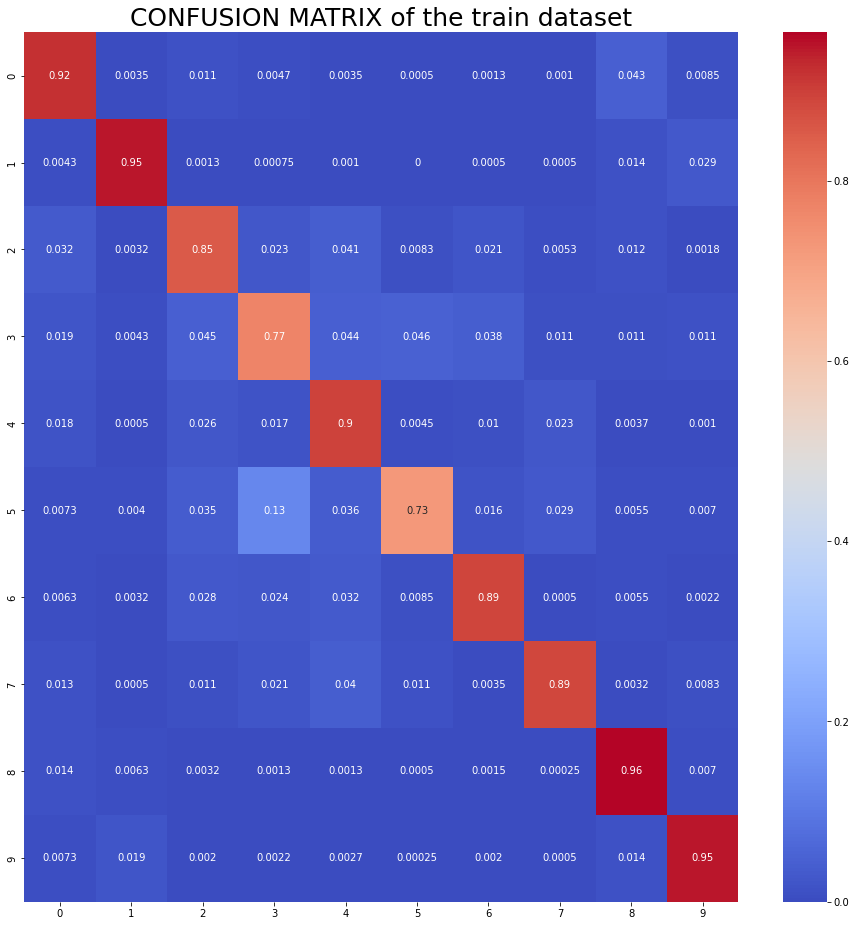

In [66]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16, 16))
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sns.heatmap(
    confusion_matrix(
        train_y_true,
        train_y_pred,
        normalize ='true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the train dataset", fontsize=25)
plt.show()

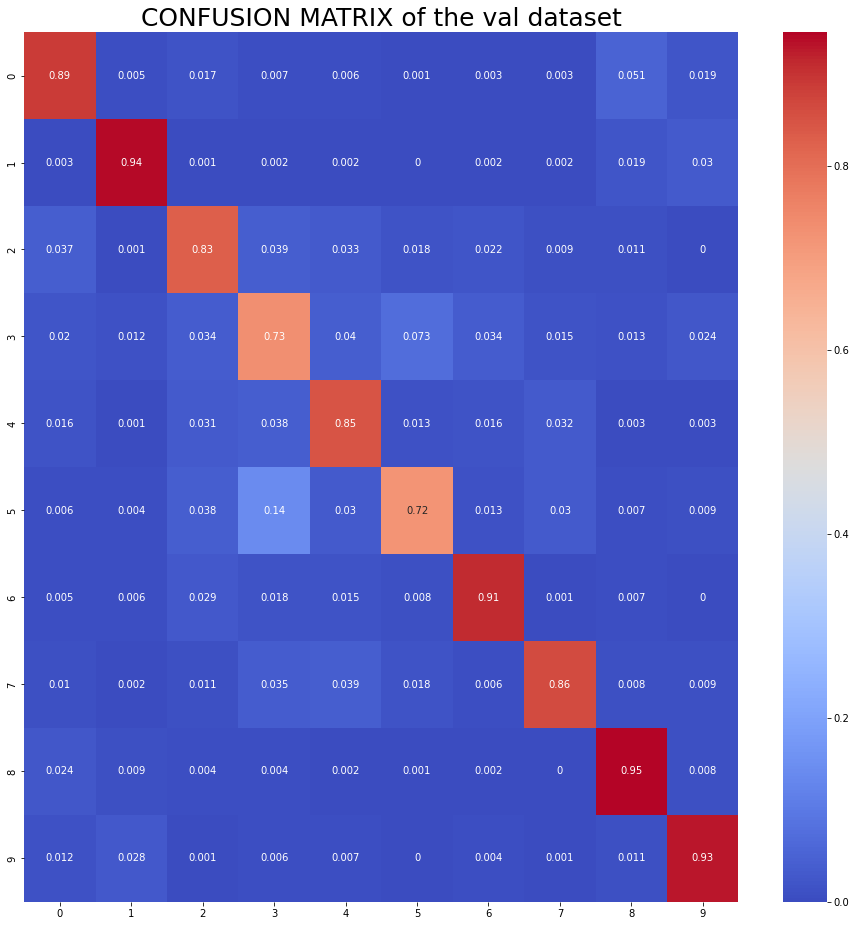

In [71]:
plt.figure(figsize=(16, 16))
sns.heatmap(
    confusion_matrix(
        val_y_true,
        val_y_pred,
        normalize = 'true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the val dataset", fontsize=25)
plt.show()

# 추론 

이제 학습이 완료되었습니다! 

그럼 test 데이터를 예측해 보아요.

test 데이터를 불어옵니다.

In [72]:
from glob import glob
import PIL.Image
import numpy as np

test_images = []

path = './data/'
for filename in sorted(glob(path + "test/*.jpg")):
    an_img = PIL.Image.open(filename) 
    img_array = np.array(an_img) 
    test_images.append(img_array) 

test_images = np.array(test_images)

In [73]:
class CustomDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform 
        self.img_list = test_images
        self.img_labels = [0] * 10000 

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(image=self.img_list[idx]), self.img_labels[idx]

In [74]:
test_set = CustomDataset(transform=else_transform)

test_loader = DataLoader(test_set, batch_size = test_batch_size)

In [76]:
def test(model, loader, epoch, nb_epochs):

    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)

In [77]:
next(iter(test_loader))[0]['image'][0].shape

torch.Size([3, 224, 224])

본격적으로 test 데이터를 예측해보아요! 

예측을 할 때는 학습이 진행되지 않도록 net.eval() 코드를 작성해주어야 합니다. 

데이터가 backpropagation 되어 가중치가 수정되지 않도록 해주는 코드입니다. 

In [79]:
import pandas as pd
sample_submission = pd.read_csv('./data/sample_submission.csv')

model.eval()

batch_index = 0
with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
        images = images['image'].to(device)
        outputs = model(images)
        batch_index = i * test_batch_size
        max_vals, max_indices = torch.max(outputs, 1)
        sample_submission.iloc[batch_index:batch_index + test_batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

예측된 데이터의 라벨은 숫자로 되어있습니다. 

train 데이터를 불러올 때 ImageFolder 메소드를 사용해 데이터를 불러왔기 때문입니다. 

제출을 위해 라벨을 다시 복원 시켜 줍니다.

In [80]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)

In [81]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,airplane
2,0002.jpg,airplane
3,0003.jpg,cat
4,0004.jpg,airplane


In [84]:
sample_submission.to_csv(f'{np.max(val_acc_list):.4f}_'+f'{save_name}.csv', index=False)

축하합니다! 데이터 분석을 완료하셨습니다!

앞으로도 데이콘과 함께 즐겁게 데이터 분석 능력을 키워가시면 좋겠습니다.

감사합니다.